In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [8]:
df = pd.read_excel('Online Retail.xlsx')
df = df[df['CustomerID'].notna()]

KeyboardInterrupt: ignored

In [9]:
df_fix = df.sample(10000, random_state = 42)
df_fix.shape


(10000, 8)

In [10]:
#F2
df_fix = df.sample(10000, random_state = 42)
print(df_fix)
#null finns ej
df_fix.drop('Country', inplace=True, axis=1)
print(df_fix)
#droppar country, bättre än dummy data. Nu finns enbart numerisk data.
#TODO: hur fixar man outliers? ANNA?


#F2

       InvoiceNo StockCode  ... CustomerID         Country
47912     540456     48185  ...    13534.0  United Kingdom
342630    566891     23013  ...    14894.0  United Kingdom
288183   C562139     21313  ...    12921.0  United Kingdom
325368    565438     22382  ...    17229.0  United Kingdom
331450    566016     21212  ...    15144.0  United Kingdom
...          ...       ...  ...        ...             ...
123       536381     22083  ...    15311.0  United Kingdom
449041   C575082     21843  ...    12613.0         Germany
425967    573340     21733  ...    14159.0  United Kingdom
70029     541997     22919  ...    18077.0  United Kingdom
282657    561653     20992  ...    14002.0  United Kingdom

[10000 rows x 8 columns]
       InvoiceNo StockCode  ... UnitPrice  CustomerID
47912     540456     48185  ...      7.95     13534.0
342630    566891     23013  ...      3.95     14894.0
288183   C562139     21313  ...      0.85     12921.0
325368    565438     22382  ...      1.65     1722

In [13]:
from datetime import datetime,timedelta
df_fix["InvoiceDate"] = df_fix["InvoiceDate"]
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

snapshot_date = max(df_fix.InvoiceDate) + timedelta(days=1)

customers = df_fix.groupby(['CustomerID']).agg({
   'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

customers.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

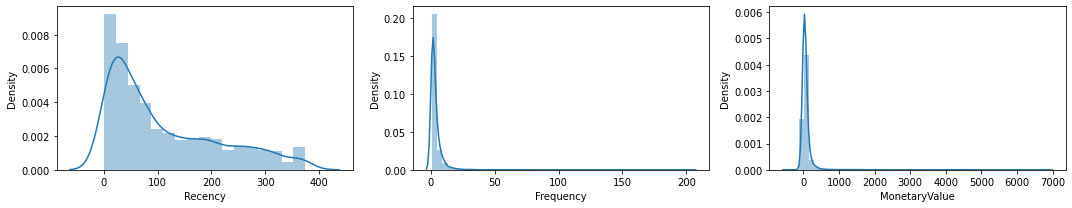

In [14]:
#Visualisera distributionen av data i våra tre variabler 
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [15]:
print(customers['Recency'].skew().round(2))
print(customers['Frequency'].skew().round(2))
print(customers['MonetaryValue'].skew().round(2))

0.93
14.77
16.63


F4:

Recency är bäst. det ser vi både genom grafen som är tydligare. samt genom skew som visar att recency är 0.93. Vi vill gärna ha nära 1. 

In [18]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


In [17]:
print(customers_fix['Recency'].skew().round(2))
print(customers_fix['Frequency'].skew().round(2))
print(customers_fix['MonetaryValue'].skew().round(2))

-0.1
0.16
1.16


F5.

recency har blivit nästintill perfekt då den är extremt nära 0. 

Frecency är också bra nu.
MonetaryValue har även den fått en klar förbättring sedan tidigare. 

Frecency och MonetaryValue har båda fått en större förbättring, men detta då recency redan var okej-bra. 

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[ 0. -0.  0.]
[1. 1. 1.]


F6

a. Vilken typ av transformering har gjorts? Varför?
KMeans - så att datan hamnar vid de närmaste klustrena.



c. Varför är det så viktigt i K-means att denna pre-processing görs?
K-Means kan inte hantera missing values 
K-means kan inte heller hantera kategoriska variabler direkt.



d. Vad för struktur är customers_normalized?
scale - 
i inlärningsalgoritmer bör funktioner vara centrerade runt noll. Scale ger ett snabbt och enkelt sätt att utföra denna åtgärd på ett dataset:

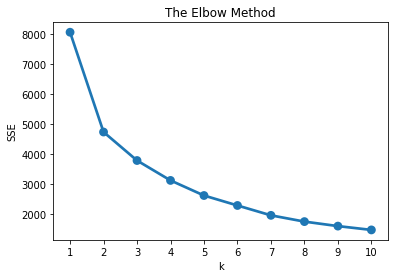

In [22]:
from sklearn.cluster import KMeans

sse = {} #sum of squared error
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

F7


a. Vilket k är lämpligast enligt armbågsmetoden? Varför?
b. Fyll i detta tal i nedanstående kod som skapar modellen genom att ersätta punkterna med rätt siffra.

K borde vara 2, eller kanske 3... "armbågen" är på 2 och visar att mycket variation förklaras. 
man vill inte att den blir överanpassad.  

In [41]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [34]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,5,133.20,1
12348.0,249,2,120.88,0
12349.0,19,2,312.75,1
12352.0,73,5,80.85,1
12354.0,233,2,33.30,0


In [35]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         157.7       1.5          25.0  1580
1          44.4       6.8         142.9  1110

In [36]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.493794,1.012426,1.017503,12347.0,1
1,1.232949,-0.017412,0.925115,12348.0,0
2,-0.994917,-0.017412,1.972690,12349.0,1
3,-0.012582,1.012426,0.572565,12352.0,1
4,1.155005,-0.017412,-0.056441,12354.0,0


In [37]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,1,Recency,-0.493794
1,12348.0,0,Recency,1.232949
2,12349.0,1,Recency,-0.994917
3,12352.0,1,Recency,-0.012582
4,12354.0,0,Recency,1.155005


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


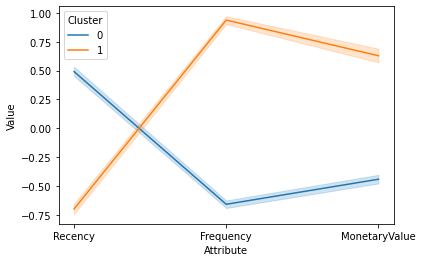

In [38]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

Recency - antalet dagar sedan en kund köpte något.
Frequency - Hur ofta en kund handlar
Monetary - För hur mycket har kunden handlat för?

*VAD SÄGER VÅR MODELL? *

a. Vad säger dessa värden om våra kunder?

b.Vad betyder värdena i den sista kolumnen, som också är ny?

c. Vad säger visualiseringen?

d.Baserat på vad vi nu vet, döp de kluster som skapats till lämpliga namn och skriv en kort rekommendation till butiken hur de bör hantera dem.